In [19]:
import os
import sys
import math
import itertools
import json
import glob
from datetime import datetime
from pathlib import Path
from typing import Any, Callable, Dict, List, Optional, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
import pandas as pd

# Add parent directory to path to find data_handling.py
sys.path.append(str(Path("..").resolve()))
from data_handling import (
    load_measurements_npz,
    load_state_npz,
    MeasurementDataset,
    MeasurementLoader
)

# Define paths
data_dir = Path("measurements")
state_dir = Path("state_vectors")
exp_dir = Path("experiments")
exp_dir.mkdir(parents=True, exist_ok=True)

# Set global device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")
print(f"Loading data from: {data_dir.resolve()}")

Running on: cpu
Loading data from: /Users/Tonni/Desktop/master-code/neural-quantum-tomo/parametric_qst/tfim_4x4/measurements


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple, Dict, Any

class Conditioner(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int, hidden_width: int):
        super().__init__()
        self.fc1 = nn.Linear(cond_dim, hidden_width)
        self.fc2 = nn.Linear(hidden_width, 2 * (num_visible + num_hidden))
        self.num_visible = num_visible
        self.num_hidden = num_hidden

    def forward(self, cond: torch.Tensor):
        x = torch.tanh(self.fc1(cond))
        x = self.fc2(x)
        return torch.split(x, [self.num_visible, self.num_visible, self.num_hidden, self.num_hidden], dim=-1)


class ConditionalRBM(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int,
                 conditioner_width: int = 64, k: int = 1, T: float = 1.0):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.k = k
        self.T = T

        self.W = nn.Parameter(torch.empty(num_visible, num_hidden))
        self.b = nn.Parameter(torch.zeros(num_visible))
        self.c = nn.Parameter(torch.zeros(num_hidden))
        self.conditioner = Conditioner(num_visible, num_hidden, cond_dim, conditioner_width)

        # Default initialization (weak) - meant to be overridden
        self.initialize_weights(std=0.01)

    def initialize_weights(self, std: float = 0.01):
        """
        Public method to re-initialize weights.
        Call this before training with dataset-specific settings.
        """
        nn.init.normal_(self.W, std=std)
        nn.init.constant_(self.b, 0.0)
        nn.init.constant_(self.c, 0.0)

    # --- Symmetrized scoring ---
    def _free_energies_pair(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor):
        v = v.to(dtype=self.W.dtype, device=self.W.device)
        v_W = v @ self.W
        W_sum = self.W.sum(dim=0)

        linear_v = v_W + c_mod
        linear_f = W_sum.unsqueeze(0) - v_W + c_mod

        term2_v = F.softplus(linear_v).sum(dim=-1)
        term2_f = F.softplus(linear_f).sum(dim=-1)

        term1_v = -(v * b_mod).sum(dim=-1)
        term1_f = -((1.0 - v) * b_mod).sum(dim=-1)

        return (term1_v - term2_v), (term1_f - term2_f)

    def _free_energy(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor) -> torch.Tensor:
        F_v, F_f = self._free_energies_pair(v, b_mod, c_mod)
        stacked = torch.stack([-F_v, -F_f], dim=-1)
        return -self.T * torch.logsumexp(stacked / self.T, dim=-1)

    # --- Conditioning ---
    def _compute_effective_biases(self, cond: torch.Tensor):
        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(cond)
        if cond.dim() == 1:
            b_mod = (1.0 + gamma_b) * self.b + beta_b
            c_mod = (1.0 + gamma_c) * self.c + beta_c
        else:
            b_mod = (1.0 + gamma_b) * self.b.unsqueeze(0) + beta_b
            c_mod = (1.0 + gamma_c) * self.c.unsqueeze(0) + beta_c
        return b_mod, c_mod

    # --- Symmetrized Sampling ---
    def _sample_h_given_v(self, v_eff: torch.Tensor, c_mod: torch.Tensor, rng: torch.Generator) -> torch.Tensor:
        p_h = torch.sigmoid((v_eff @ self.W + c_mod) / self.T)
        return torch.bernoulli(p_h, generator=rng)

    def _sample_v_given_h(self, a: torch.Tensor, b_mod: torch.Tensor, rng: torch.Generator) -> torch.Tensor:
        p_v = torch.sigmoid((a + b_mod) / self.T)
        return torch.bernoulli(p_v, generator=rng)

    @staticmethod
    def _apply_flip(v: torch.Tensor, s0: torch.Tensor) -> torch.Tensor:
        return s0 * v + (1.0 - s0) * (1.0 - v)

    def _sample_s_given_v_h(self, v: torch.Tensor, a: torch.Tensor, b_mod: torch.Tensor, rng: torch.Generator) -> torch.Tensor:
        vb   = (v * b_mod).sum(dim=-1)
        va   = (v * a).sum(dim=-1)
        bsum = b_mod.sum(dim=-1)
        asum = a.sum(dim=-1)
        dE = (-bsum - asum + 2.0 * vb + 2.0 * va)
        p_s0 = torch.sigmoid(dE / self.T)
        return torch.bernoulli(p_s0, generator=rng).to(v.dtype).unsqueeze(-1)

    def _gibbs_step_sym_fast(self, v: torch.Tensor, h: torch.Tensor, s0: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor, rng: torch.Generator):
        v = v.to(dtype=self.W.dtype, device=self.W.device)
        if b_mod.dim() == 1: b_mod = b_mod.unsqueeze(0).expand(v.size(0), -1)
        if c_mod.dim() == 1: c_mod = c_mod.unsqueeze(0).expand(v.size(0), -1)

        # 1. h | v,s
        v_eff = self._apply_flip(v, s0)
        h = self._sample_h_given_v(v_eff, c_mod, rng)
        a = h @ self.W.t()

        # 2. s | v,h
        s0 = self._sample_s_given_v_h(v, a, b_mod, rng)

        # 3. v | h,s
        v_eff = self._sample_v_given_h(a, b_mod, rng)
        v_next = self._apply_flip(v_eff, s0)

        return v_next, h, s0

    # --- Forward & Scoring ---
    def log_score(self, v: torch.Tensor, cond: torch.Tensor) -> torch.Tensor:
        b_mod, c_mod = self._compute_effective_biases(cond)
        return -0.5 * self._free_energy(v, b_mod, c_mod) / self.T

    def forward(self, batch: Tuple[torch.Tensor, ...], aux_vars: Dict[str, Any]):
        v_data, _, cond = batch
        v_data = v_data.to(device=self.W.device, dtype=self.W.dtype)
        cond = cond.to(device=self.W.device, dtype=self.W.dtype)
        rng = aux_vars.get("rng")

        b_mod, c_mod = self._compute_effective_biases(cond)

        # Noise
        v_model = v_data.clone()
        n_noise = int(v_data.shape[0] * aux_vars.get("noise_frac", 0.1))
        if n_noise > 0:
            v_model[:n_noise] = torch.bernoulli(torch.full_like(v_model[:n_noise], 0.5), generator=rng)

        # Init chain
        B = v_model.size(0)
        s0 = torch.bernoulli(torch.full((B, 1), 0.5, device=v_model.device, dtype=v_model.dtype), generator=rng)
        h = torch.zeros((B, self.num_hidden), device=v_model.device, dtype=v_model.dtype)

        # Run Chain
        for _ in range(self.k):
            v_model, h, s0 = self._gibbs_step_sym_fast(v_model, h, s0, b_mod, c_mod, rng)
        v_model = v_model.detach()

        fe_data = self._free_energy(v_data, b_mod, c_mod)
        fe_model = self._free_energy(v_model, b_mod, c_mod)
        return fe_data.mean() - fe_model.mean(), {}

    @torch.no_grad()
    def get_normalized_wavefunction(self, cond: torch.Tensor, all_states: torch.Tensor) -> torch.Tensor:
        if cond.dim() == 1: cond = cond.unsqueeze(0)
        cond_exp = cond.expand(all_states.shape[0], -1)

        old_T = self.T
        self.T = 1.0
        log_psi = self.log_score(all_states, cond_exp)
        self.T = old_T

        log_norm_sq = torch.logsumexp(2.0 * log_psi, dim=0)
        return torch.exp(log_psi - 0.5 * log_norm_sq)

In [21]:
def get_sigmoid_curve(high, low, steps, falloff):
    center = steps / 2.0
    def fn(step):
        s = min(step, steps)
        return float(low + (high - low) / (1.0 + math.exp(falloff * (s - center))))
    return fn

def train(model, optimizer, loader, num_epochs, rng, lr_schedule_fn):
    global_step = 0
    model.train()
    training_noise_frac = 0.1

    print(f"{'Epoch':<6} | {'Loss':<10} | {'LR':<10}")
    print("-" * 30)

    for epoch in range(num_epochs):
        tot_loss = 0.0
        for batch in loader:
            lr = lr_schedule_fn(global_step)
            for g in optimizer.param_groups: g["lr"] = lr

            optimizer.zero_grad(set_to_none=True)
            loss, _ = model(batch, {"rng": rng, "noise_frac": training_noise_frac})
            loss.backward()
            optimizer.step()
            tot_loss += loss.item()
            global_step += 1

        if (epoch + 1) % 10 == 0:
            print(f"{epoch+1:<6} | {tot_loss/len(loader):+.4f}     | {lr:.6f}")

    return model

def generate_all_states(num_qubits: int, device: torch.device):
    lst = list(itertools.product([0, 1], repeat=num_qubits))
    return torch.tensor(lst, dtype=torch.float32, device=device)

@torch.no_grad()
def compute_overlap(model, h_val, gt_path, all_states):
    psi_np, _ = load_state_npz(gt_path)
    psi_true = torch.from_numpy(psi_np).real.float().to(device)
    psi_true = psi_true / torch.norm(psi_true)

    cond = torch.tensor([h_val], device=device, dtype=torch.float32)
    psi_model = model.get_normalized_wavefunction(cond, all_states)

    return torch.abs(torch.dot(psi_true, psi_model)).item()

In [22]:
GEN_SIDE_LENGTH = 4
FILE_SAMPLE_COUNT = 5_000_000   # Assuming you have large files
N_EPOCHS = 50

# --- CONFIGURATION FROM PROMPT ---
# You can add 10_000 and 50_000 to this list later
SAMPLE_SIZES = [2_000, 5_000, 20_000]

# The training set (Files to load)
h_train_support = [1.00, 2.00, 3.00, 4.00, 5.00, 6.00, 7.00]

# The evaluation set (For plotting)
h_eval_novel   = [1.50, 2.50, 2.80, 3.20, 3.50, 4.50, 5.50]
all_h_eval     = sorted(list(set(h_train_support + h_eval_novel)))

# Construct file paths based on training support
file_names = [f"tfim_{GEN_SIDE_LENGTH}x{GEN_SIDE_LENGTH}_h{h:.2f}_{FILE_SAMPLE_COUNT}.npz" for h in h_train_support]
file_paths = [data_dir / fn for fn in file_names]

# Verify files exist
missing = [fp for fp in file_paths if not fp.exists()]
if missing:
    print(f"Warning: {len(missing)} files missing. Check data directory.")
    # Filter to exist only so we don't crash
    file_paths = [fp for fp in file_paths if fp.exists()]

seed = 42
torch.manual_seed(seed)
rng = torch.Generator().manual_seed(seed)

print(f"Starting Experiment Loop: {SAMPLE_SIZES}")

for n_samples in SAMPLE_SIZES:
    print(f"\n>>> RUNNING: {n_samples} samples per support point <<<")

    # 1. Dataset (loads specific limit n_samples)
    ds = MeasurementDataset(file_paths, load_measurements_npz, ["h"], [n_samples]*len(file_paths))
    loader = MeasurementLoader(ds, batch_size=1024, shuffle=True, drop_last=False, rng=rng)

    # 2. Model (Standard Symmetrized Config)
    # Using k=10 as established for stability
    model = ConditionalRBM(ds.num_qubits, num_hidden=64, cond_dim=1, conditioner_width=64, k=10).to(device)

    # EXPLICIT INITIALIZATION CALL
    # Use std=0.1 for 2k/10k. If you add 50k later, you might want to try std=0.01 or keep 0.1
    current_std = 0.05 # 0.1 has even better results but not so didactical
    model.initialize_weights(std=current_std)
    print(f"Model initialized with std={current_std}")

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    scheduler = get_sigmoid_curve(1e-2, 1e-4, N_EPOCHS*len(loader), 0.005)

    # 3. Train
    model = train(model, optimizer, loader, N_EPOCHS, rng, scheduler)

    # 4. Evaluation
    print("Evaluating...")
    all_states = generate_all_states(GEN_SIDE_LENGTH**2, device)
    results = []

    for h_val in all_h_eval:
        gt_path = state_dir / f"tfim_{GEN_SIDE_LENGTH}x{GEN_SIDE_LENGTH}_h{h_val:.2f}.npz"
        if not gt_path.exists(): continue

        ov = compute_overlap(model, h_val, gt_path, all_states)

        # Classify based on the training support list
        rtype = "support" if h_val in h_train_support else "novel"
        results.append({"h": h_val, "overlap": ov, "type": rtype})

    # 5. Save Report
    run_id = f"streamlined_{n_samples}"
    report = {
        "config": {"n_samples": n_samples, "epochs": N_EPOCHS, "std": current_std},
        "results": results
    }
    with open(exp_dir / f"{run_id}_report.json", "w") as f:
        json.dump(report, f, indent=2)

    print(f"Run {run_id} complete.")

print("\nAll experiments finished.")

Starting Experiment Loop: [2000, 5000, 20000]

>>> RUNNING: 2000 samples per support point <<<
Model initialized with std=0.05
Epoch  | Loss       | LR        
------------------------------
10     | +0.0622     | 0.007443
20     | +0.0198     | 0.005920
30     | +0.0274     | 0.004204
40     | +0.0116     | 0.002676
50     | -0.0260     | 0.001572
Evaluating...
Run streamlined_2000 complete.

>>> RUNNING: 5000 samples per support point <<<
Model initialized with std=0.05
Epoch  | Loss       | LR        
------------------------------
10     | +0.0002     | 0.009334
20     | -0.0031     | 0.007098
30     | +0.0162     | 0.003023
40     | +0.0058     | 0.000772
50     | -0.0042     | 0.000224
Evaluating...
Run streamlined_5000 complete.

>>> RUNNING: 20000 samples per support point <<<
Model initialized with std=0.05
Epoch  | Loss       | LR        
------------------------------
10     | +0.0076     | 0.010000
20     | +0.0048     | 0.009689
30     | -0.0039     | 0.000414
40     | -0.

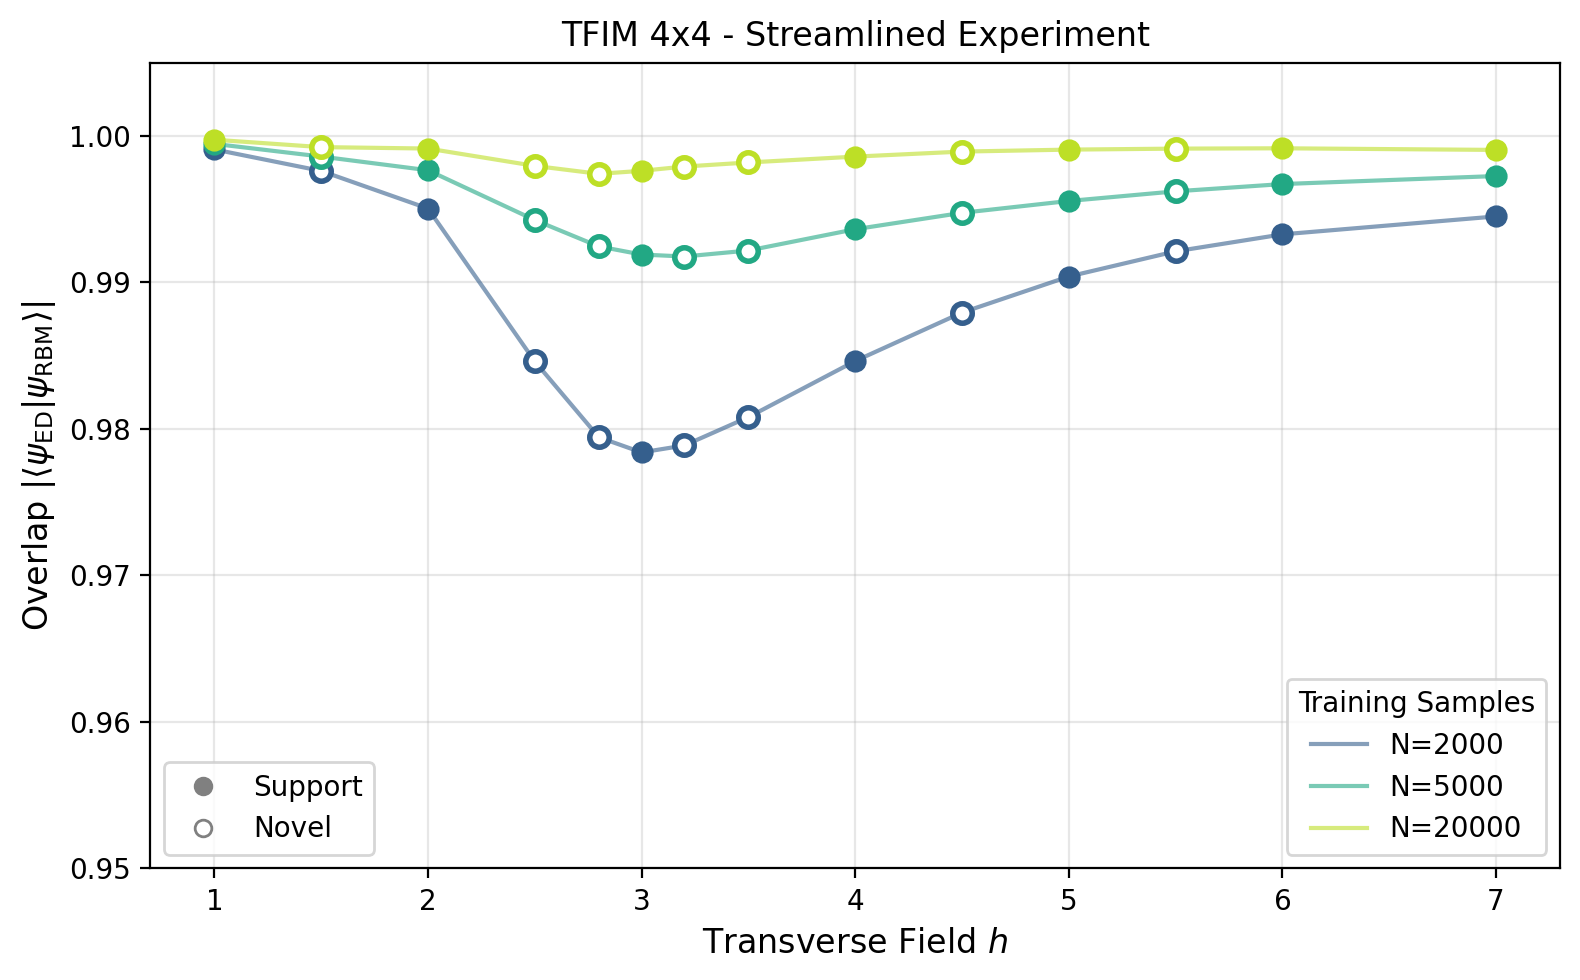

In [23]:
# Load all reports
report_files = sorted(glob.glob(str(exp_dir / "*_report.json")))
experiments = []
for fpath in report_files:
    with open(fpath, "r") as f: experiments.append(json.load(f))

# Sort by sample size
experiments.sort(key=lambda x: x["config"]["n_samples"])

plt.figure(figsize=(8, 5), dpi=200)
colors = cm.viridis(np.linspace(0.3, 0.9, len(experiments)))

# Loop creates lines for every experiment in the directory (2k, 10k, 50k...)
for i, exp in enumerate(experiments):
    n = exp["config"]["n_samples"]
    df = pd.DataFrame(exp["results"]).sort_values("h")

    supp = df[df["type"] == "support"]
    nov  = df[df["type"] == "novel"]

    c = colors[i]
    if len(experiments) == 1: c = 'tab:blue' # Default blue if single line

    # Line
    plt.plot(df["h"], df["overlap"], '-', color=c, alpha=0.6, label=f"N={n}")
    # Support
    plt.plot(supp["h"], supp["overlap"], 'o', color=c, markersize=7)
    # Novel
    plt.plot(nov["h"], nov["overlap"], 'o', color=c, markerfacecolor='white', markeredgewidth=2, markersize=7)

plt.xlabel(r"Transverse Field $h$", fontsize=12)
plt.ylabel(r"Overlap $|\langle \psi_\mathrm{ED} | \psi_\mathrm{RBM} \rangle|$", fontsize=12)
plt.title(f"TFIM {GEN_SIDE_LENGTH}x{GEN_SIDE_LENGTH} - Streamlined Experiment", fontsize=12)

# Legends
color_leg = plt.legend(loc='lower right', title="Training Samples")
plt.gca().add_artist(color_leg)

custom_lines = [
    Line2D([0], [0], color='gray', marker='o', linestyle='None', label='Support'),
    Line2D([0], [0], color='gray', marker='o', markerfacecolor='white', linestyle='None', label='Novel')
]
plt.legend(handles=custom_lines, loc='lower left')

plt.ylim(0.95, 1.005)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()